## Exploratory Data Analysis:  Movie Ratings and Common Sense Metrics
### Import Non-text Features and convert to Pandas DataFrame for analysis

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import requests, json, csv, copy
import matplotlib.pyplot as plt
import math
import random

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load json of movies_features_text
with open('data/movies_other_features.json') as json_file:  
    movies_other_features = json.load(json_file)

In [3]:
df = pd.DataFrame(movies_other_features)

In [4]:
### Eliminate spaces in front of MPAA ratings, to allow handling
df.MPAA_rating = df.MPAA_rating.map(lambda x: x.strip())

In [5]:
### Eliminate spaces in front of genre, to allow handling
df.genre = df.genre.map(lambda x: x.strip())

In [6]:
### Create ordinal list of MPAA movie ratings, to facilitate recommendations
mpaa_dict = {'G':0, 'PG':1, 'PG-13':2, 'R':3, 'NR':4, 'NC-17':5}

In [7]:
### Create new feature, MPAA_ordinal
df['MPAA_ordinal'] = df['MPAA_rating'].map(lambda x: mpaa_dict[x])

In [8]:
df[0:7]

,Consumerism,"Drinking, Drugs & Smoking",Educational Value,Language,MPAA_rating,Positive Messages,Positive Role Models & Representations,Sex,Sexy Stuff,Violence,Violence & Scariness,age,genre,movie_id,one_line_description,overall_rating,slug,title,MPAA_ordinal
0,0.0,3.0,NaN,4.0,R,1.0,0.0,0.0,NaN,4.0,NaN,17,Thriller,0,"Solid drug war sequel has intense violence, la...",3,sicario-day-of-the-soldado,Sicario: Day of the Soldado,3
1,0.0,3.0,NaN,4.0,R,0.0,1.0,3.0,NaN,4.0,NaN,16,Western,1,"Unusual, uneven Western has violence, language...",3,damsel,Damsel,3
2,0.0,2.0,NaN,0.0,R,1.0,1.0,0.0,NaN,3.0,NaN,15,Thriller,2,Rapid-fire disturbing images in paranoid thril...,2,distorted,Distorted,3
3,0.0,1.0,NaN,3.0,R,3.0,3.0,2.0,NaN,3.0,NaN,15,Thriller,3,"Well-made spy thriller has some war violence, ...",4,the-catcher-was-a-spy,The Catcher Was a Spy,3
4,0.0,4.0,NaN,4.0,R,1.0,1.0,4.0,NaN,2.0,NaN,16,Comedy,4,Indie road-trip dramedy has pot dealing/smoking.,2,boundaries,Boundaries,3
5,1.0,3.0,NaN,5.0,NR,1.0,1.0,3.0,NaN,2.0,NaN,16,Comedy,5,"Swearing, smoking, drinking in slight but appe...",3,izzy-gets-the-fck-across-town,Izzy Gets the F*ck Across Town,4
6,3.0,1.0,NaN,2.0,PG-13,3.0,3.0,1.0,NaN,4.0,NaN,13,Action/Adventure,6,"Intense dino sequel has scary, jump-worthy vio...",3,jurassic-world-fallen-kingdom,Jurassic World: Fallen Kingdom,2


### Exploratory Data Analysis:

In [9]:
# All movie rating features have at least one null value. Each feature is examined in detail
# to determine how to impute values while compromising our data the least.
def find_NaNs_left_to_clean(df=df):
    return df.loc[:, df.isnull().sum() != 0].isnull().sum()

In [10]:
find_NaNs_left_to_clean(df)

Consumerism                                 56
Drinking, Drugs & Smoking                   35
Educational Value                         7295
Language                                    22
Positive Messages                          376
Positive Role Models & Representations    2147
Sex                                       2038
Sexy Stuff                                6617
Violence                                  2031
Violence & Scariness                      6600
dtype: int64

In [11]:
# Visual inspection has lead me to believe that 0. can be safely imputed for the following
# features:
feature_zero = ['Consumerism', 'Drinking, Drugs & Smoking', 'Language', 'Positive Messages', 'Sex', 'Violence']

In [12]:
for feature in feature_zero:
    df[feature].fillna(0., inplace=True)

In [13]:
find_NaNs_left_to_clean(df)

Educational Value                         7295
Positive Role Models & Representations    2147
Sexy Stuff                                6617
Violence & Scariness                      6600
dtype: int64

### Why Sexy Stuff and Sex? Violence and Violence and Scariness?
#### Movies for Young Children are evaluated using different scales than those for teens:  Sexy Stuff, and Violence & Scariness are often used as scales for marital embraces or cartoon scariness as opposed to nudity or blood and gore in Sex and Violence ratings. Sexy Stuff, Violence & Scariness, and Educational Value are only present in movies recommended for children aged 8 and younger by Common Sense Media (see below). Consequently, boolean features were created to facilitate future data handling involving these features (e.g., 'is\_educational' is a 1 when any rating was given for 'Educational Value', etc.)
#### Decision made to leave NaN's in these categories since there was no good way to impute them without destroying their reason for being.

In [14]:
### Create new column, ['is_educational'], that is 1 if any rating or 0 if NaN
df['is_educational'] = df['Educational Value'].notnull().map(int)

In [15]:
### Create new column, ['has_Sexy_Stuff'], that is 1 if any rating or 0 if NaN
df['has_Sexy_Stuff'] = df['Sexy Stuff'].notnull().map(int)

In [16]:
### Create new column, ['has_Violence_&_Scariness'], that is 1 if any rating or 0 if NaN
df['has_Violence_&_Scariness'] = df['Violence & Scariness'].notnull().map(int)

### Minimum Age Recommendations and MPAA Ratings

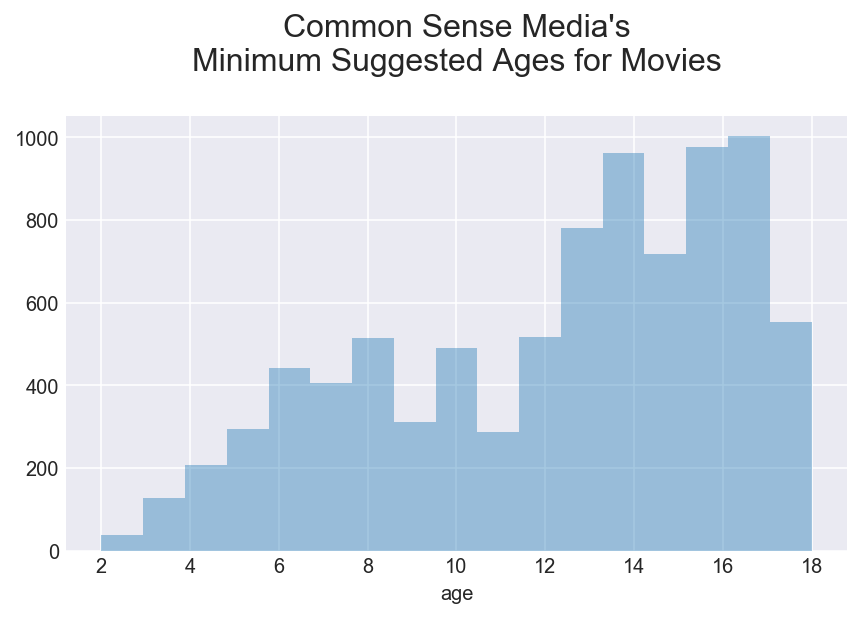

In [60]:
fig = plt.figure(figsize=(7,4))
ax = fig.gca()

ax = sns.distplot(df['age'], bins=17, kde = False)

ax.set_title('Common Sense Media\'s\nMinimum Suggested Ages for Movies\n', fontsize=16)
plt.show()

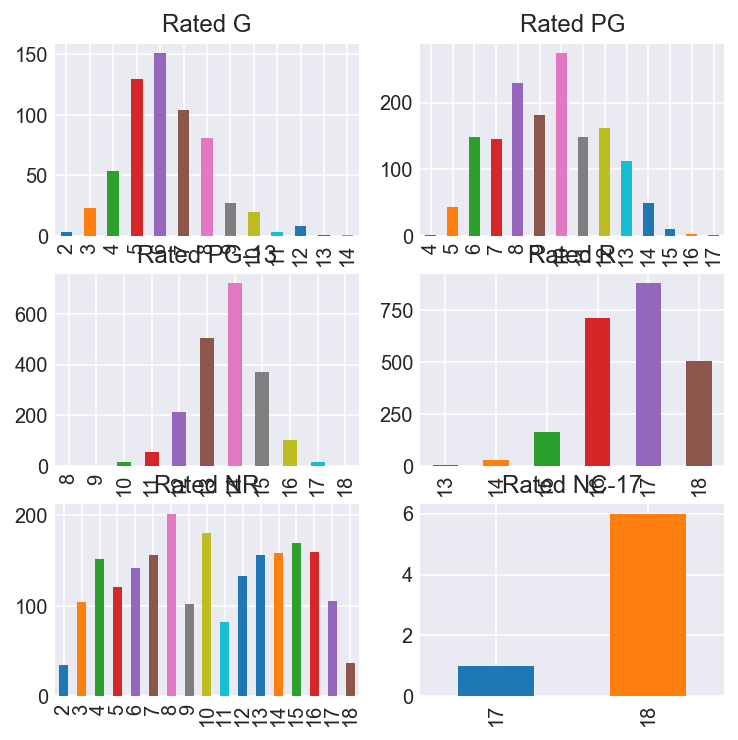

In [18]:
fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(321)
df[df['MPAA_rating']=='G']['age'].value_counts().sort_index().plot(kind='bar')
ax2 = fig.add_subplot(322)
df[df['MPAA_rating']=='PG']['age'].value_counts().sort_index().plot(kind='bar')
ax3 = fig.add_subplot(323)
df[df['MPAA_rating']=='PG-13']['age'].value_counts().sort_index().plot(kind='bar')
ax4 = fig.add_subplot(324)
df[df['MPAA_rating']=='R']['age'].value_counts().sort_index().plot(kind='bar')
ax5 = fig.add_subplot(325)
df[df['MPAA_rating']=='NR']['age'].value_counts().sort_index().plot(kind='bar')
ax6 = fig.add_subplot(326)
df[df['MPAA_rating']=='NC-17']['age'].value_counts().sort_index().plot(kind='bar')

ax1.title.set_text('Rated G')
ax2.title.set_text('Rated PG')
ax3.title.set_text('Rated PG-13')
ax4.title.set_text('Rated R')
ax5.title.set_text('Rated NR')
ax6.title.set_text('Rated NC-17')

plt.show()

fig.tight_layout();

In [19]:
df[df['MPAA_rating']=='G']['age'].mean()

6.306930693069307

In [20]:
df[df['MPAA_rating']=='PG']['age'].mean()

9.459352280237939

In [21]:
df[df['MPAA_rating']=='PG-13']['age'].mean()

13.732133933033483

In [22]:
df[df['MPAA_rating']=='R']['age'].mean()

16.71621034332899

In [23]:
df[df['MPAA_rating']=='NR']['age'].describe()

count    2197.000000
mean       10.102868
std         4.398250
min         2.000000
25%         6.000000
50%        10.000000
75%        14.000000
max        18.000000
Name: age, dtype: float64

In [24]:
df[df['MPAA_rating']=='NC-17']['age'].mean()

17.857142857142858

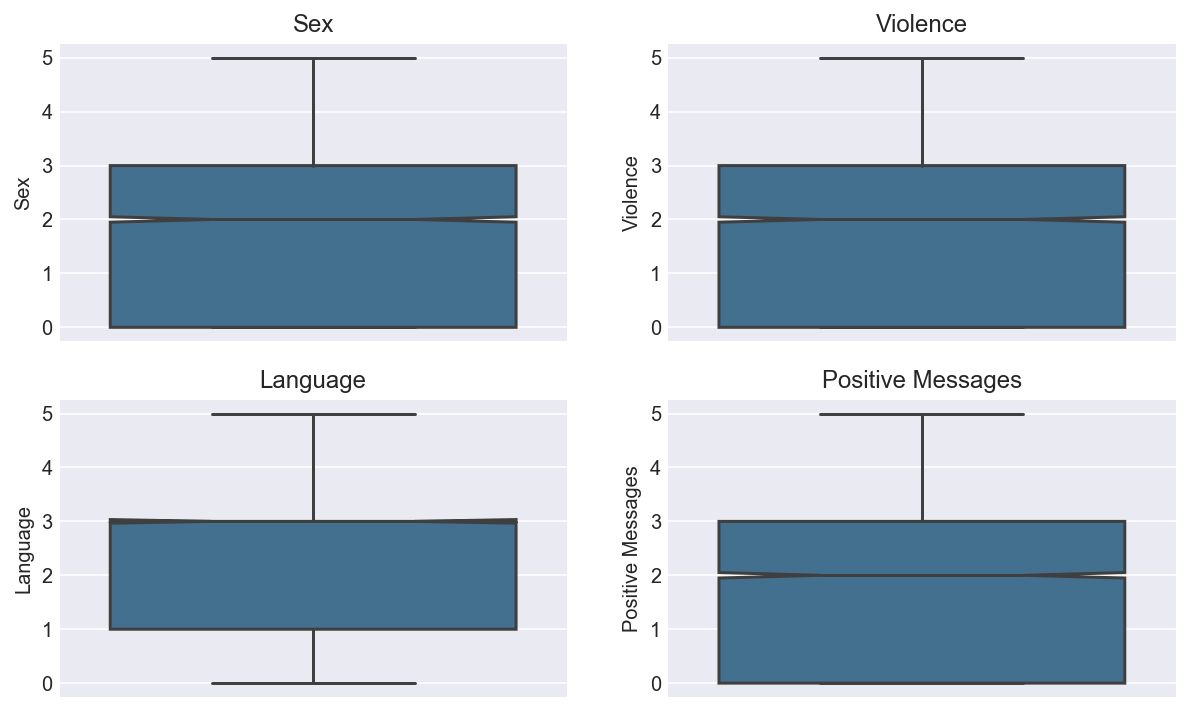

In [25]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(221)
sns.boxplot(df['Sex'],
           orient='v',
           fliersize=8,
           linewidth=1.5,
           notch=True,
           saturation=0.5)
ax2 = fig.add_subplot(222)
sns.boxplot(df['Violence'],
           orient='v',
           fliersize=8,
           linewidth=1.5,
           notch=True,
           saturation=0.5)
ax3 = fig.add_subplot(223)
sns.boxplot(df['Language'],
           orient='v',
           fliersize=8,
           linewidth=1.5,
           notch=True,
           saturation=0.5)
ax4 = fig.add_subplot(224)
sns.boxplot(df['Positive Messages'],
           orient='v',
           fliersize=8,
           linewidth=1.5,
           notch=True,
           saturation=0.5)
ax1.title.set_text('Sex')
ax2.title.set_text('Violence')
ax3.title.set_text('Language')
ax4.title.set_text('Positive Messages')
plt.show()

fig.tight_layout();

In [26]:
df['Educational Value'].value_counts()

0.0    519
1.0    431
2.0    200
3.0    104
4.0     55
5.0     21
Name: Educational Value, dtype: int64

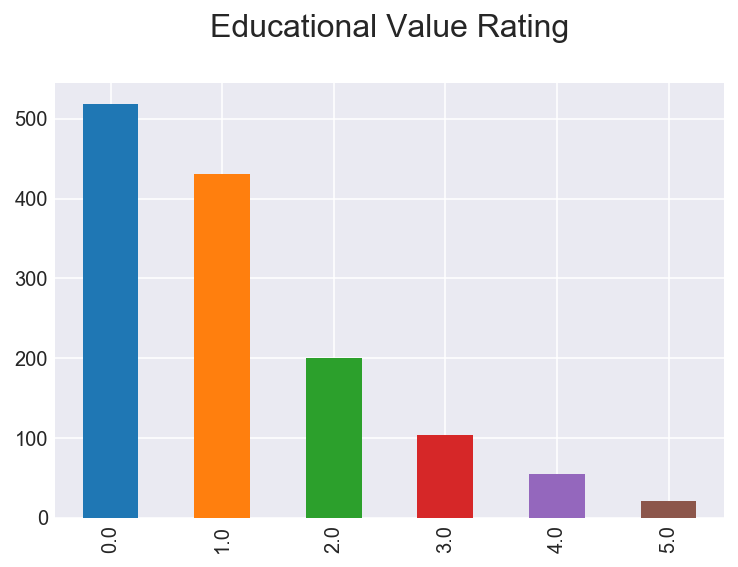

In [64]:
ax = df['Educational Value'].value_counts().plot(kind='bar')
ax.set_title("Educational Value Rating\n", fontsize=16)
fig.tight_layout();

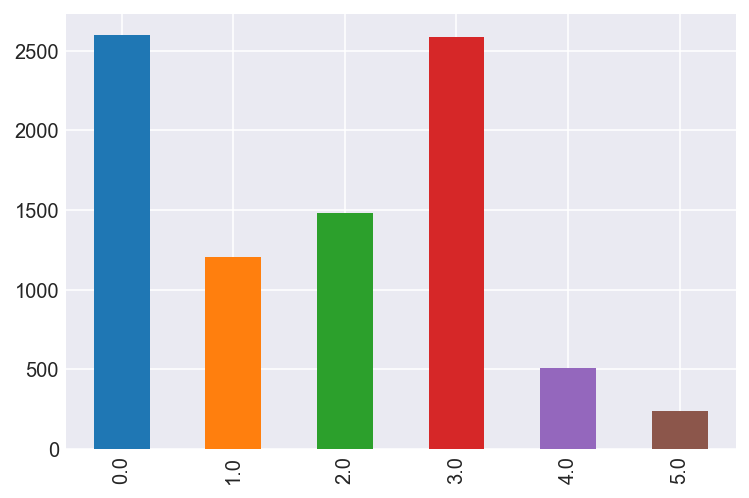

In [28]:
df['Drinking, Drugs & Smoking'].value_counts().sort_index().plot(kind='bar')

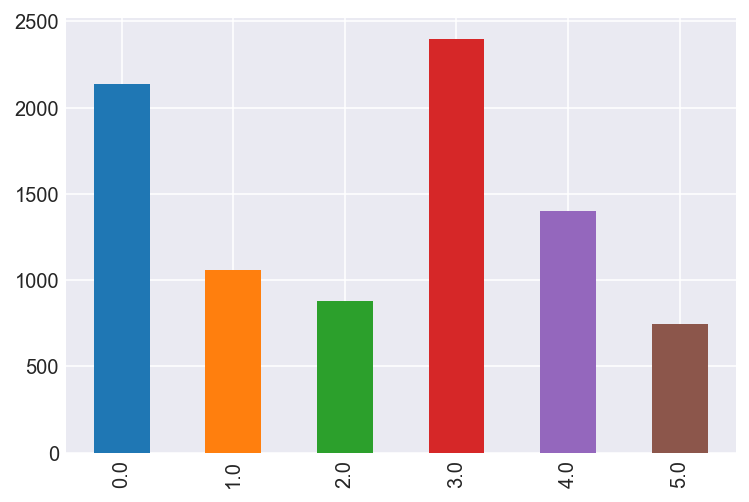

In [29]:
df['Language'].value_counts().sort_index().plot(kind='bar')

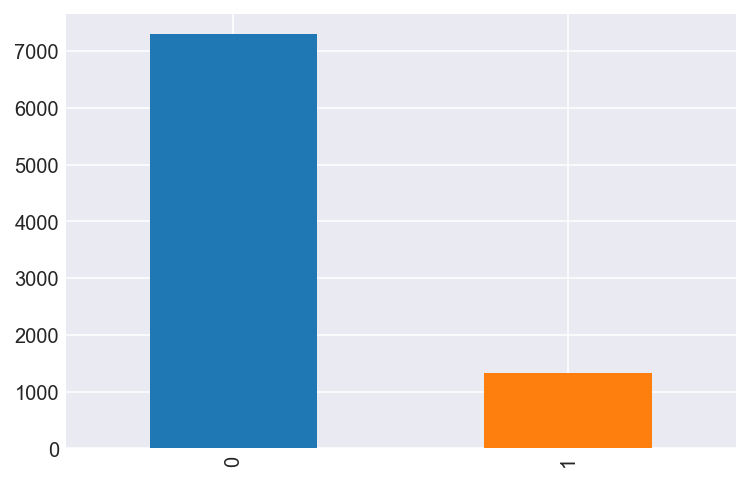

In [30]:
df['is_educational'].value_counts().plot(kind='bar')

In [31]:
df[df['is_educational'] ==1]['age'].describe()

count    1330.000000
mean        6.009774
std         1.586928
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max         8.000000
Name: age, dtype: float64

### Sexy Stuff

In [32]:
df['Sexy Stuff'].value_counts()

0.0    1339
1.0     534
2.0     110
3.0      25
Name: Sexy Stuff, dtype: int64

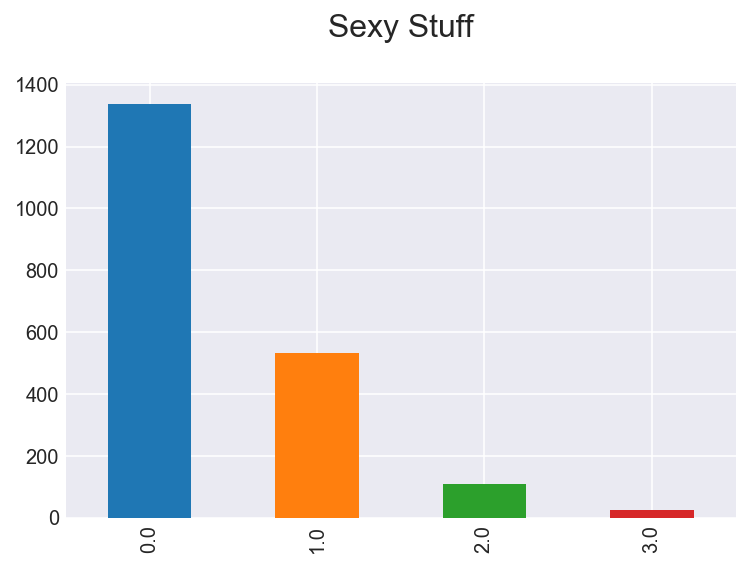

In [68]:
ax = df['Sexy Stuff'].value_counts().plot(kind='bar')
ax.set_title("Sexy Stuff\n", fontsize=16)
fig.tight_layout();

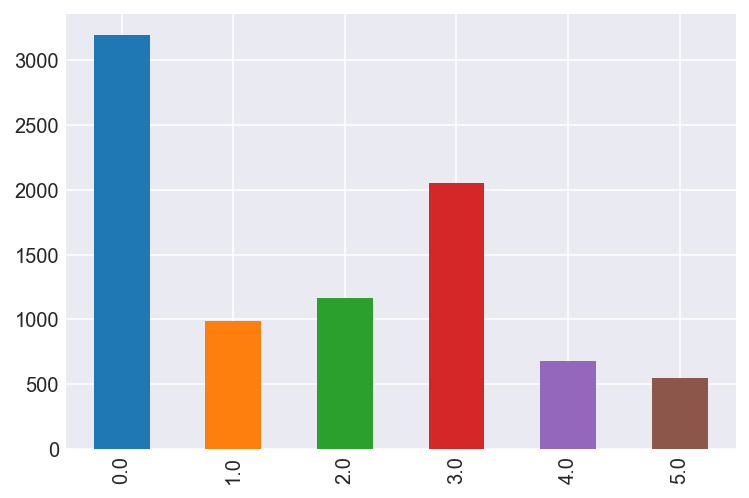

In [67]:
df['Sex'].value_counts().sort_index().plot(kind='bar')

In [35]:
df[df['has_Sexy_Stuff'] ==1]['age'].describe()

count    2008.000000
mean        6.110060
std         1.609432
min         2.000000
25%         5.000000
50%         6.000000
75%         8.000000
max         8.000000
Name: age, dtype: float64

### Violence & Scariness

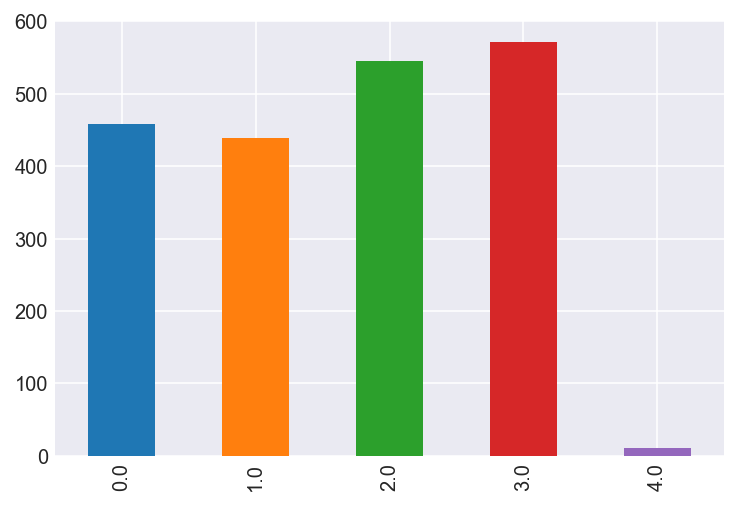

In [36]:
df['Violence & Scariness'].value_counts().sort_index().plot(kind='bar')

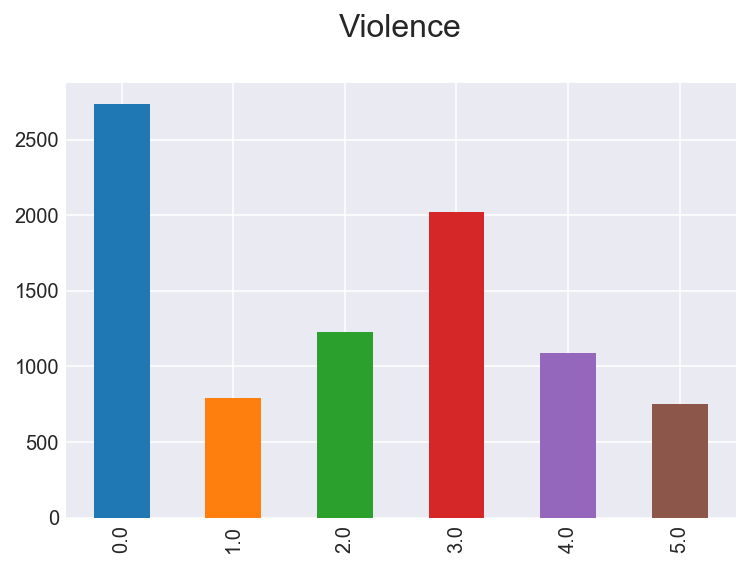

In [69]:
ax = df['Violence'].value_counts().sort_index().plot(kind='bar')
ax.set_title("Violence\n", fontsize=16)
fig.tight_layout();

In [38]:
df[df['has_Violence_&_Scariness'] ==1]['age'].describe()

count    2025.000000
mean        6.098272
std         1.617201
min         2.000000
25%         5.000000
50%         6.000000
75%         8.000000
max         8.000000
Name: age, dtype: float64

#### Visual inspection of a subset of movies with a NaN for Sex and any value for Sexy Stuff revealed that Sexy Stuff does not even rise to a 1 on the Sex meter. These should also be set to zero. Likewise, nothing on the Violence & Scariness scale rose to even a 1 on the Violence metric, so these can safely be set to zero as well.

In [39]:
df['Sex'].fillna(0., inplace=True)
df['Violence'].fillna(0., inplace=True)

### Positive Role Models & Representations

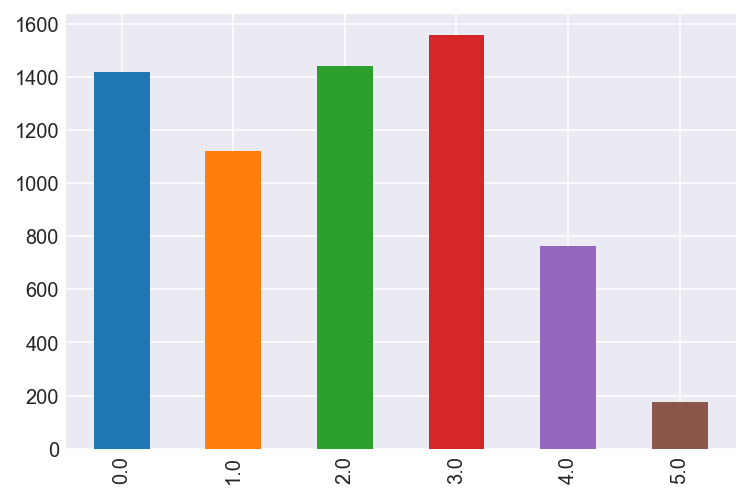

In [40]:
df['Positive Role Models & Representations'].value_counts().sort_index().plot(kind='bar')

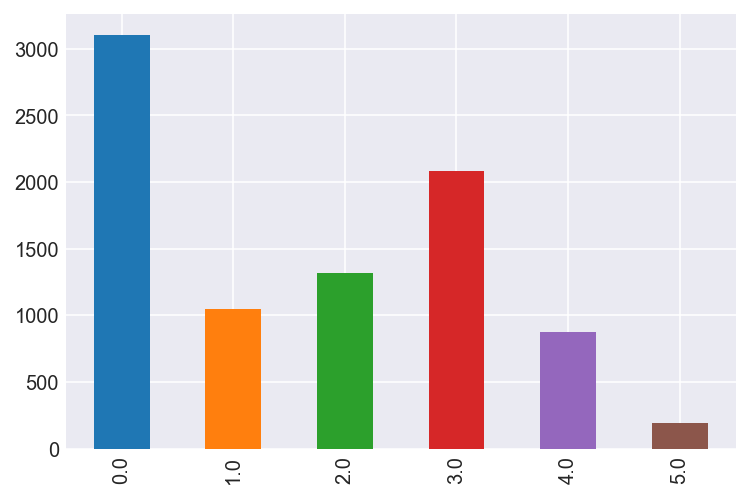

In [41]:
df['Positive Messages'].value_counts().sort_index().plot(kind='bar')

In [42]:
### Create new column, ['has_Positive_Role_Models_&_Representations'],
### that is 1 if any rating or 0 if NaN
for movie in range(len(df)):
    if math.isnan(df['Positive Role Models & Representations'][movie]) == True:
        df.loc[movie, 'has_Positive_Role_Models_&_Representations'] = 0
    else:
        df.loc[movie, 'has_Positive_Role_Models_&_Representations']= 1

In [43]:
df[df['has_Positive_Role_Models_&_Representations'] ==1]['age'].describe()

count    6478.000000
mean       12.116857
std         4.142784
min         2.000000
25%         9.000000
50%        13.000000
75%        16.000000
max        18.000000
Name: age, dtype: float64

In [44]:
df[df['Positive Role Models & Representations'].isnull()]

,Consumerism,"Drinking, Drugs & Smoking",Educational Value,Language,MPAA_rating,Positive Messages,Positive Role Models & Representations,Sex,Sexy Stuff,Violence,...,movie_id,one_line_description,overall_rating,slug,title,MPAA_ordinal,is_educational,has_Sexy_Stuff,has_Violence_&_Scariness,has_Positive_Role_Models_&_Representations
335,3.0,0.0,2.0,1.0,NR,3.0,NaN,0.0,0.0,0.0,...,438,More adventures of Kion and his Guard; cartoon...,4,the-lion-guard-the-rise-of-scar,The Lion Guard: The Rise of Scar,4,1,1,1,0.0
587,2.0,0.0,0.0,0.0,NR,2.0,NaN,0.0,0.0,0.0,...,691,Fine for fans; new viewers may be confused. So...,2,digimon-adventure-tri-determination,Digimon Adventure tri: Determination,4,1,1,1,0.0
2267,1.0,3.0,NaN,3.0,NR,2.0,NaN,3.0,NaN,4.0,...,2375,"'60s Fellini classic has sex, drinking, suicide.",4,la-dolce-vita,La Dolce Vita,4,0,0,0,0.0
2768,2.0,0.0,0.0,1.0,NR,2.0,NaN,0.0,1.0,0.0,...,2881,Toddler Bratz look unrealistic but promote tea...,2,bratz-babyz-save-christmas,Bratz Babyz Save Christmas,4,1,1,1,0.0
4052,0.0,0.0,NaN,0.0,NR,0.0,NaN,0.0,NaN,3.0,...,4167,This story of deaf musician is a real treasure.,4,playing-from-the-heart,Playing from the Heart,4,0,0,0,0.0
4121,0.0,3.0,NaN,0.0,NR,0.0,NaN,3.0,NaN,3.0,...,4236,Faithful adaptation of classic family story.,3,a-tree-grows-in-brooklyn,A Tree Grows in Brooklyn,4,0,0,0,0.0
4293,3.0,3.0,NaN,0.0,NR,0.0,NaN,4.0,NaN,0.0,...,4410,"Frank, thoughtful look at teen sexuality and HIV.",4,girl-positive,"Girl, Positive",4,0,0,0,0.0
4312,3.0,3.0,NaN,0.0,NR,0.0,NaN,3.0,NaN,3.0,...,4429,"Romcom is cute, but story is based on deception.",3,my-fake-fiance,My Fake Fiance,4,0,0,0,0.0
4316,0.0,0.0,NaN,0.0,NR,2.0,NaN,0.0,NaN,1.0,...,4433,Powerful look at the impact of technology on o...,4,digital-nation-life-on-the-virtual-frontier,Digital Nation: Life on the Virtual Frontier,4,0,0,0,0.0
4324,0.0,0.0,NaN,0.0,G,3.0,NaN,0.0,0.0,0.0,...,4441,Stunning vision of the beautiful -- and fragil...,4,under-the-sea-3d,Under the Sea 3D,0,0,1,1,0.0


#### No discernable pattern to null values in these movies for Positive Role Models & Representations. Decided to drop this variable entirely as including it may lead to false recommendations.

In [45]:
df.drop(columns='Positive Role Models & Representations', inplace=True)

In [46]:
df.drop(columns='has_Positive_Role_Models_&_Representations', inplace=True)

#### Save df for next notebook:  develop non-text filter to augment recommender system, indexing by movie title.

In [47]:
# movies_processed_nontext_features.set_index('title', inplace=True)

In [48]:
movies_processed_nontext_features = df

In [49]:
movies_processed_nontext_features.to_csv('data/movies_processed_nontext_features.csv')

In [50]:
movies_processed_nontext_features.head()

,Consumerism,"Drinking, Drugs & Smoking",Educational Value,Language,MPAA_rating,Positive Messages,Sex,Sexy Stuff,Violence,Violence & Scariness,...,genre,movie_id,one_line_description,overall_rating,slug,title,MPAA_ordinal,is_educational,has_Sexy_Stuff,has_Violence_&_Scariness
0,0.0,3.0,NaN,4.0,R,1.0,0.0,NaN,4.0,NaN,...,Thriller,0,"Solid drug war sequel has intense violence, la...",3,sicario-day-of-the-soldado,Sicario: Day of the Soldado,3,0,0,0
1,0.0,3.0,NaN,4.0,R,0.0,3.0,NaN,4.0,NaN,...,Western,1,"Unusual, uneven Western has violence, language...",3,damsel,Damsel,3,0,0,0
2,0.0,2.0,NaN,0.0,R,1.0,0.0,NaN,3.0,NaN,...,Thriller,2,Rapid-fire disturbing images in paranoid thril...,2,distorted,Distorted,3,0,0,0
3,0.0,1.0,NaN,3.0,R,3.0,2.0,NaN,3.0,NaN,...,Thriller,3,"Well-made spy thriller has some war violence, ...",4,the-catcher-was-a-spy,The Catcher Was a Spy,3,0,0,0
4,0.0,4.0,NaN,4.0,R,1.0,4.0,NaN,2.0,NaN,...,Comedy,4,Indie road-trip dramedy has pot dealing/smoking.,2,boundaries,Boundaries,3,0,0,0
